# Comparing Fits and Parameters

This notebook contains sample code for exploring the fitted parameters and comparing them between the implemented models.

In this exploration, I compare motion energy and pRF location parameters.

Given our large-scale Arrow of Time video dataset, we wanted to explore to what extent we could achieve retinotopic mapping exclusively through motion energy fitting. Here, we are using data from different experimental paradigms (pRF vs Arrow of Time).

In [1]:
subject = 2

In [2]:
# imports

import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
from aot_analysis import io_utils

In [3]:
# plotting functions

def plot_scatter(xdata, ydata, xlabel, ylabel='pRF R2', xlims=None, ylims=None, alpha=.05, fit_line=False, diag_line=False, out_path=None, ax=None):
    # Set APA style defaults
    plt.rcParams.update({
        'font.size': 12,          # APA recommends a font size of 12
        'axes.labelsize': 12,     # x and y labels
        'axes.titlesize': 12,     # plot title
        'xtick.labelsize': 10,    # x tick labels
        'ytick.labelsize': 10,    # y tick labels
        'legend.fontsize': 10,    # legend font size
        # 'font.family': 'serif',   # APA recommends serif fonts
        'text.usetex': False,     # Use LaTeX for text rendering if True
        'figure.figsize': (6, 4.5), # Figure size in inches
        'figure.dpi': 100,        # Resolution of the figure
        'lines.linewidth': 2,     # Line width
        'axes.spines.top': False, # No top spine
        'axes.spines.right': False, # No right spine
        'axes.grid': False,       # No gridlines
        'axes.linewidth': 1,      # Line width of axes
    })
    
    if ax is None:
        fig = plt.figure(figsize=(6, 6))
        gs = GridSpec(4, 4)
        
        ax_main = fig.add_subplot(gs[1:4, 0:3])
        ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
        ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
    else:
        gs = GridSpec(4, 4, figure=ax.figure)
        ax_main = ax.figure.add_subplot(gs[1:4, 0:3])
        ax_histx = ax.figure.add_subplot(gs[0, 0:3], sharex=ax_main)
        ax_histy = ax.figure.add_subplot(gs[1:4, 3], sharey=ax_main)

    ax_main.scatter(xdata, ydata, alpha=alpha)
    ax_main.set_xlabel(xlabel)
    ax_main.set_ylabel(ylabel)

    combined = np.concatenate((xdata, ydata))
    minval = np.nanmin(combined)
    maxval = np.nanmax(combined)
    print(f"min = {minval}, max = {maxval}")

    if diag_line:
        diag_line = np.linspace(minval, maxval, 10)
        ax_main.plot(diag_line, diag_line, color='black', linestyle='--')

    xdata = np.nan_to_num(xdata)
    ydata = np.nan_to_num(ydata)
    slope, intercept, r_value, p_value, std_err = linregress(xdata, ydata)
    
    if fit_line:
        print(f"r = {r_value}, p = {p_value}, se = {std_err}")
        fitted_line = slope * xdata + intercept
        ax_main.plot(xdata, fitted_line, color='red', label=f'r = {r_value:.2f}')
        ax_main.legend()

    if xlims:
        ax_main.set_xlim(xlims)
    if ylims:
        ax_main.set_ylim(ylims)

    ax_histx.hist(xdata, bins=30, alpha=0.7)
    ax_histy.hist(ydata, bins=30, orientation='horizontal', alpha=0.7)

    if ax is None:
        plt.tight_layout()
        if out_path:
            plt.savefig(out_path)
        plt.show()

In [4]:
# load config
config = io_utils.load_config()
DIR_DERIVATIVES = Path(config['paths']['derivatives'])
DIR_FIGURES = Path(config['paths']['figures'])

# load results
subject_str = f'sub-{str(subject).zfill(3)}'
subject_dir = DIR_DERIVATIVES / subject_str

prf_params = pd.read_csv(subject_dir / 'prf_analysis' / f'{subject_str}_norm_test_fit.csv')
moten_params = pd.read_csv(subject_dir / 'moten_analysis_aot_fw' / f'{subject_str}_params.csv')

# r2: arrow of time segmentation
aot_r2 = nib.load(subject_dir
         / 'GLMsingle_analysis'
         / f'{subject_str}_r2_aot_median.nii.gz').get_fdata()

aot_r2 = aot_r2.flatten()
prf_r2 = prf_params['r2'] * 100

## Quality of Fit

Exploring the bivariate distribution shows a cluster of vertices with high out-of-set quality of fit.
These neural populations appear to respond consistently to specific types of motion .
That means 
Note: Small number of vertices show extreme negative pRF R2 values.

min = -22396918643.557148, max = 92.89717279983604


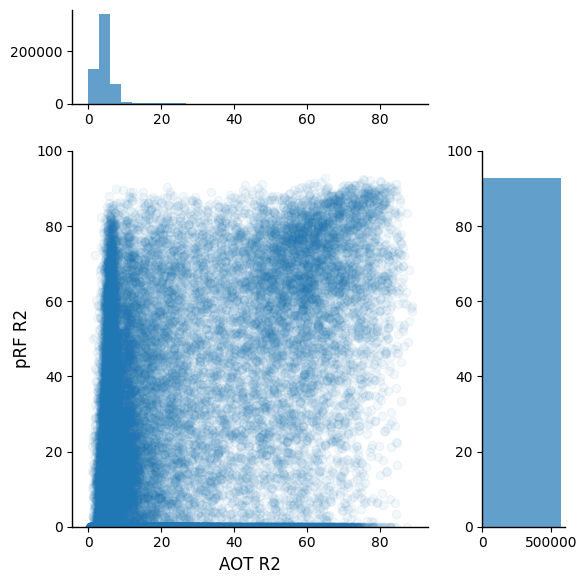

In [5]:
plot_scatter(aot_r2, prf_r2,  xlabel = 'AOT R2', ylims=[0, 100])

# Location Parameters


In [6]:
# filter for quality of fit and valid eccentricity

def create_mask(percentile_moten, percentile_prf, filter_ecc = None):
    thresh_moten = np.nanpercentile(moten_params['R2'], percentile_moten)
    thresh_prf = np.nanpercentile(prf_params['r2'], percentile_prf)
    print(f'Threshold moten: {thresh_moten:.2f}; threshold prf: {thresh_prf:.2f}')

    r2_mask = (moten_params['R2'] > thresh_moten) & (prf_params['r2'] > thresh_prf)
    if filter_ecc:
        r2_mask = r2_mask & (moten_params['ecc'] > filter_ecc[0]) & (moten_params['ecc'] < filter_ecc[1])
    return r2_mask

# # Option 1: Percentile thresholds
percentile_thresh = 99.9
r2_mask = create_mask(percentile_moten = percentile_thresh, percentile_prf = percentile_thresh, filter_ecc = (0, 10))

# # Option 2: Manually define thresholds
# rsq_threshold_moten = 0.05
# rsq_threshold_prf = 0.85
# r2_mask = (moten_params['R2'] > rsq_threshold_moten) & (prf_params['r2'] > rsq_threshold_prf)
# r2_mask = r2_mask & (moten_params['ecc'] > 0) & (moten_params['ecc'] < 10) 

Threshold moten: 0.18; threshold prf: 0.85


min = 0.8352258131885112, max = 9.97193973672645


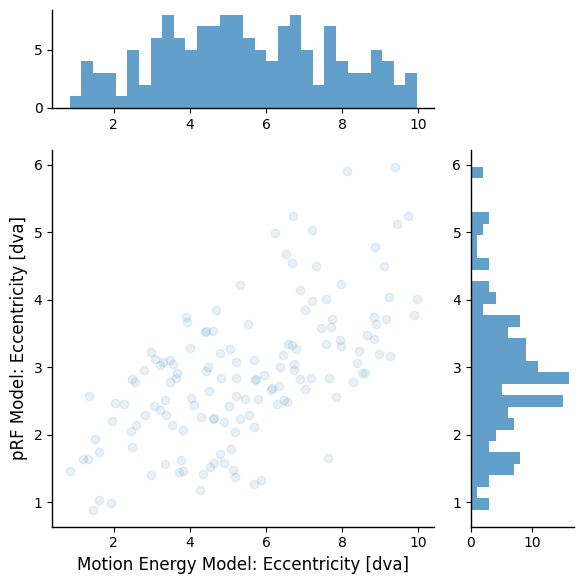

min = 0.8352258131885112, max = 9.97193973672645
r = 0.6159364428289318, p = 3.401042840660246e-16, se = 0.0298652849640544


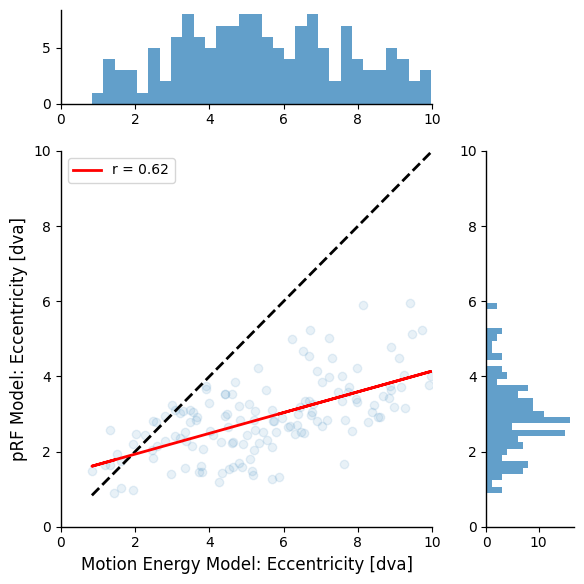

In [7]:
# plot coordinates of filtered vertices

moten_ecc = moten_params.loc[r2_mask, 'ecc']
prf_ecc = prf_params.loc[r2_mask, 'ecc']

xlabel = 'Motion Energy Model: Eccentricity [dva]'
ylabel='pRF Model: Eccentricity [dva]'
plot_scatter(moten_ecc, prf_ecc, xlabel = xlabel, ylabel=ylabel, alpha=.1)

lims = (0, 10)
plot_scatter(moten_ecc, prf_ecc, 
             xlabel = xlabel, ylabel=ylabel, 
             alpha=.1, xlims=lims, ylims=lims, fit_line=True, diag_line=True,
             out_path = DIR_FIGURES / 'moten_vs_prf_ecc.pdf')

The correlation between pRF and motion energy eccentricities is moderately high. However, there appears to be a positive bias in the motion energy parameters.

min = -3.138189779817857, max = 3.1388683660255787


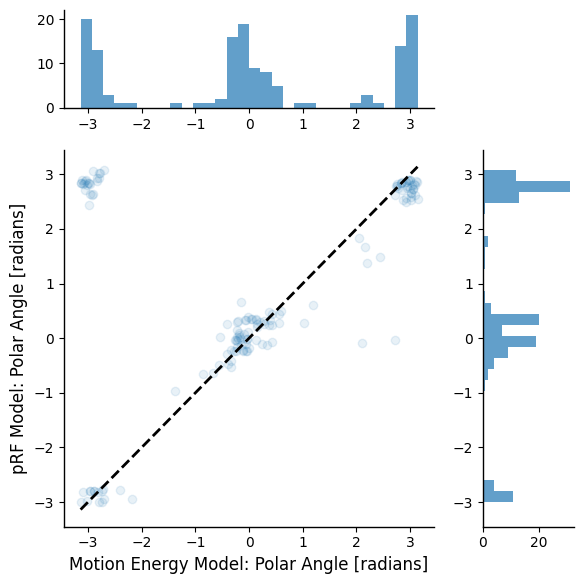

In [8]:
prf_polar = prf_params.loc[r2_mask, 'polar']
moten_polar = moten_params.loc[r2_mask, 'polar']

xlabel = 'Motion Energy Model: Polar Angle [radians]'
ylabel = 'pRF Model: Polar Angle [radians]'

plot_scatter(moten_polar, prf_polar, 
             xlabel = xlabel, ylabel=ylabel, 
             alpha=.1,
             diag_line=True, fit_line=False,
             out_path = DIR_FIGURES / 'moten_vs_prf_polar.pdf')



Both models display considerable anisotropy, with most (thresholded!) vertices being at the horizontal meridian.

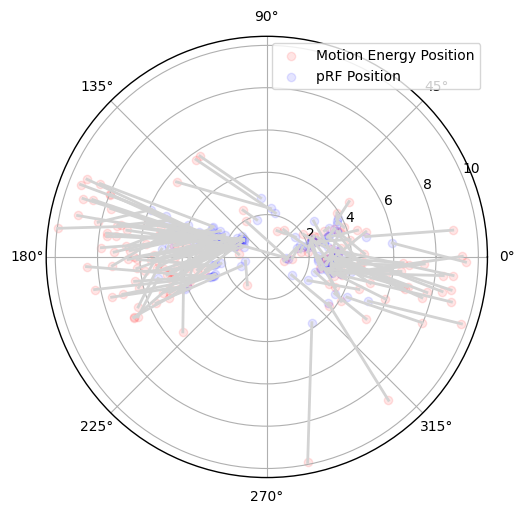

In [9]:
moten_pos = moten_params.loc[r2_mask, ['polar', 'ecc', 'R2']]
prf_pos = prf_params.loc[r2_mask, ['polar', 'ecc', 'r2']]
residuals_polar = moten_params['polar'] - prf_params['polar']
residuals_ecc = moten_params['ecc'] - prf_params['ecc']


# Create polar plot
fig = plt.figure(figsize=(10, 5))

# Polar plot
ax_polar = fig.add_subplot(121, polar=True)
alpha = .1
# Scatter plot for predicted positions
ax_polar.scatter(moten_pos['polar'], moten_pos['ecc'], alpha=alpha, color='red', label='Motion Energy Position')

# Scatter plot for ground truth positions
ax_polar.scatter(prf_pos['polar'], prf_pos['ecc'], alpha=alpha, color='blue', label='pRF Position')

# Connect corresponding points with lines
for i in range(len(moten_pos)):

    ax_polar.plot(
        [prf_pos.iloc[i, 0],moten_pos.iloc[i, 0]], [prf_pos.iloc[i, 1], moten_pos.iloc[i, 1]], alpha=1, color='lightgray')

ax_polar.legend()
plt.tight_layout()
plt.show()

Viewing the coordinates in a circular plot shows the bivariate shifts in the motion energy position vs the pRF parameters. There is a systematic, positive bias in eccentricity whereas the polar angle coordinates are mostly consistent with those fit by the pRF model.

The relative lack of vertices shown here is likely a result of natural anisotropy of the visual system, further amplified by the strict thresholding we enforced on quality of fit.

For more in-depth insights, we conduct further analyses by investigating the full distribution of parameters in given ROIs.